In [2]:
!pip install funcsigs -U
!pip install urllib3==1.25.4  -U
!pip install matplotlib
!pip install scipy
!pip install sklearn
!pip install transformers

In [2]:
cd ..

/home/x1112373/clinicalBERT/CS598-project


In [29]:
for data_set in ['train', 'test', 'val']:
    train = pd.read_csv(f'/home/x1112373/clinicalBERT/data/3days/{data_set}.csv') 
    print(train.groupby(['ID', 'Label']).mean().reset_index().Label.value_counts())

0.0    2824
1.0    2339
Name: Label, dtype: int64
1.0    263
0.0    255
Name: Label, dtype: int64
0.0    293
1.0    287
Name: Label, dtype: int64


In [33]:
#train = pd.read_csv(f'/home/x1112373/clinicalBERT/data/3days/{data_set}.csv') 
train.ID.nunique()

580

In [30]:
2339 + 255 + 287

2881

In [31]:
2824 + 263 + 293

3380

In [20]:
pd.read_csv('/home/x1112373/clinicalBERT/data/3days/val.csv').Label.value_counts()

1.0    2986
0.0    2788
Name: Label, dtype: int64

In [21]:
23892 + 2537 + 2788

29217

In [4]:
cd .. 

/home/x1112373/clinicalBERT/CS598-project


In [5]:
from modeling.modeling_utils import *

In [6]:
processors = {
        "readmission": readmissionProcessor
    }
processor = processors['readmission']()
label_list = processor.get_labels()

train_examples = processor.get_train_examples('/home/x1112373/clinicalBERT/data/3days/')
test_example = processor.get_test_examples('/home/x1112373/clinicalBERT/data/3days/')
dev_example = processor.get_dev_examples('/home/x1112373/clinicalBERT/data/3days/')

04/14/2022 09:55:31 - INFO - modeling.modeling_utils -   LOOKING AT /home/x1112373/clinicalBERT/data/3days/train.csv


In [7]:
labels = set(label_list)

In [8]:
target_names = list(set(labels))
label2idx = {label: idx for idx, label in enumerate(target_names)}
print(label2idx)

{'1': 0, '0': 1}


In [9]:
len(train_examples)

47793

In [10]:
pwd

'/home/x1112373/clinicalBERT/CS598-project'

In [11]:
from transformers import AutoTokenizer, AutoModel, BertTokenizer
BERT_MODEL = "pretraining"
proxies = {'http': 'http://10.40.84.229:10203', 'https': 'http://10.40.84.229:10203'}
#tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name_or_path='/home/x1112373/clinicalBERT/BioClinicalBERT_Tokenizer')
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased', proxies=proxies) 
#model = AutoModel.from_pretrained(BERT_MODEL)

In [12]:
import torch
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=2)

In [13]:
MAX_SEQ_LENGTH = 128
BATCH_SIZE = 32
EVAL_BATCH = 2
train_features = convert_examples_to_features(
        train_examples, label_list, MAX_SEQ_LENGTH, tokenizer)
test_features = convert_examples_to_features(
        test_example, label_list, MAX_SEQ_LENGTH, tokenizer)
dev_features = convert_examples_to_features(
        dev_example, label_list, MAX_SEQ_LENGTH, tokenizer)

Token indices sequence length is longer than the specified maximum sequence length for this model (557 > 512). Running this sequence through the model will result in indexing errors
04/14/2022 09:56:21 - INFO - modeling.modeling_utils -   *** Example ***
04/14/2022 09:56:21 - INFO - modeling.modeling_utils -   guid: train-0
04/14/2022 09:56:21 - INFO - modeling.modeling_utils -   tokens: [CLS] have a significant family history of cancer . occupation : drugs : tobacco : alcohol : other : ( per om ##r ) : the patient is a previous mechanical engineer . he smoked occasionally but quit 35 years ago . he denies any alcohol use . lives alone and is independent . no close relatives in the area . siblings in . review of systems : flows ##hee ##t data as of 10 : 26 pm vital signs hem ##od ##yna ##mic monitoring fluid balance 24 hours since am t ##max : 6 c ( 8 tc ##urrent : 6 c ( 8 hr : 106 ( 106 - 121 ) bp ##m bp : 129 / 59 ( 72 ) { 129 / 58 [SEP]
04/14/2022 09:56:21 - INFO - modeling.modeling

Max Sequence Length: 1016


04/14/2022 09:57:25 - INFO - modeling.modeling_utils -   *** Example ***
04/14/2022 09:57:25 - INFO - modeling.modeling_utils -   guid: val-0
04/14/2022 09:57:25 - INFO - modeling.modeling_utils -   tokens: [CLS] 10 : 11 pm chest ( pre - op pa & la ##t ) clip # reason : corona ##ry artery disease admitting diagnosis : corona ##ry artery disease medical condition : 77 year old woman with reason for this examination : pre - op final report indication : 77 year old pre - op for cab ##g . technique : pa and lateral radio ##graphs . comparison : findings : the heart is enlarged . there are bilateral pl ##eur ##al e ##ff ##usions , right greater than left with associated minor ate ##le ##cta ##tic changes at the lung bases . the pulmonary va ##scu ##lat ##ure appears somewhat prominent with an upper zone redistribution . there is no p ##ne ##um ##otho ##ra [SEP]
04/14/2022 09:57:25 - INFO - modeling.modeling_utils -   input_ids: 101 2184 1024 2340 7610 3108 1006 3653 1011 6728 6643 1004 2474

Max Sequence Length: 807
Max Sequence Length: 869


In [14]:
from torch.utils.data import TensorDataset, DataLoader, SequentialSampler

def get_data_loader(features, max_seq_length, batch_size, shuffle=True): 

    all_input_ids = torch.tensor([f.input_ids for f in features], dtype=torch.long)
    all_input_mask = torch.tensor([f.input_mask for f in features], dtype=torch.long)
    all_segment_ids = torch.tensor([f.segment_ids for f in features], dtype=torch.long)
    all_label_ids = torch.tensor([f.label_id for f in features], dtype=torch.long)
    data = TensorDataset(all_input_ids, all_input_mask, all_segment_ids, all_label_ids)

    dataloader = DataLoader(data, shuffle=shuffle, batch_size=batch_size)
    return dataloader
train_dataloader = get_data_loader(train_features, MAX_SEQ_LENGTH, BATCH_SIZE, shuffle=True)
dev_dataloader = get_data_loader(dev_features, MAX_SEQ_LENGTH, EVAL_BATCH, shuffle=False)
test_dataloader = get_data_loader(test_features, MAX_SEQ_LENGTH, EVAL_BATCH, shuffle=False)


In [ ]:
!pip uninstall datascience -y
!pip install pytorch-pretrained-bert pytorch-nlp -U

In [15]:
from bert_utils import BertForSequenceClassification
#torch.cuda.empty_cache()
model = BertForSequenceClassification.from_pretrained('/home/x1112373/clinicalBERT/CS598-project/pretraining', 1)
model.to(device)

04/14/2022 09:57:33 - INFO - bert_utils -   loading archive file /home/x1112373/clinicalBERT/CS598-project/pretraining
04/14/2022 09:57:33 - INFO - bert_utils -   Model config {
  "attention_probs_dropout_prob": 0.1,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "max_position_embeddings": 512,
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "type_vocab_size": 2,
  "vocab_size": 30522
}



in the modeling class


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): BertLayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): BertLayerNorm()
              (dropout): Dropout(p=0.1, inplace=False)
            )
    

In [16]:
### best setting until now for clinicalbert_new_2.pt
from transformers.optimization import get_linear_schedule_with_warmup
from pytorch_pretrained_bert.optimization import BertAdam
GRADIENT_ACCUMULATION_STEPS = 1
NUM_TRAIN_EPOCHS = 3
LEARNING_RATE = 5e-5
WARMUP_PROPORTION = 0.1
MAX_GRAD_NORM = 3

num_train_steps = int(len(train_dataloader.dataset) / BATCH_SIZE / GRADIENT_ACCUMULATION_STEPS * NUM_TRAIN_EPOCHS)
num_warmup_steps = int(WARMUP_PROPORTION * num_train_steps)

param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
    ]

#optimizer = AdamW(optimizer_grouped_parameters, lr=LEARNING_RATE, correct_bias=True)
optimizer = BertAdam(optimizer_grouped_parameters,
                             lr=LEARNING_RATE,
                             warmup=WARMUP_PROPORTION,
                             t_total=num_train_steps)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=num_warmup_steps, num_training_steps=num_train_steps)

04/14/2022 09:57:40 - INFO - pytorch_pretrained_bert.modeling -   Better speed can be achieved with apex installed from https://www.github.com/nvidia/apex .


In [19]:
m = nn.Sigmoid()

In [ ]:
import torch
import os
from tqdm import trange
from tqdm import tqdm_notebook as tqdm
from sklearn.metrics import classification_report, precision_recall_fscore_support
import copy
import pandas as pd
import logging
logging.basicConfig(format = '%(asctime)s - %(levelname)s - %(name)s -   %(message)s', 
                    datefmt = '%m/%d/%Y %H:%M:%S',
                    level = logging.INFO)
logger = logging.getLogger(__name__)

OUTPUT_DIR = "/tmp/"
MODEL_FILE_NAME = "pytorch_model.bin"
PATIENCE = 5
GRADIENT_ACCUMULATION_STEPS_list = [1, 2, 4, 8]
#LEARNING_RATE_list = [2e-5, 5e-5]
LEARNING_RATE_list = [5e-5]
MAX_GRAD_NORM_list = [1,3,5]
NUM_TRAIN_EPOCHS = 3
WARMUP_PROPORTION = 0.1

for LEARNING_RATE in LEARNING_RATE_list:
    for GRADIENT_ACCUMULATION_STEPS in GRADIENT_ACCUMULATION_STEPS_list:
        num_train_steps = int(len(train_dataloader.dataset) / BATCH_SIZE / GRADIENT_ACCUMULATION_STEPS * NUM_TRAIN_EPOCHS)
        num_warmup_steps = int(WARMUP_PROPORTION * num_train_steps)

        param_optimizer = list(model.named_parameters())
        no_decay = ['bias', 'gamma', 'beta']
        optimizer_grouped_parameters = [
            {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
            {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
            ]

        #optimizer = AdamW(optimizer_grouped_parameters, lr=LEARNING_RATE, correct_bias=True)
        optimizer = BertAdam(optimizer_grouped_parameters,
                                     lr=LEARNING_RATE,
                                     warmup=WARMUP_PROPORTION,
                                     t_total=num_train_steps)
        scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=num_warmup_steps, num_training_steps=num_train_steps)
        loss_history = []
        train_loss_history = []
        auroc_history = []

        no_improvement = 0
        global_step = 0 
        global_step_check=0
        for real_epoch in trange(int(NUM_TRAIN_EPOCHS), desc="Epoch"):
            real_epoch = real_epoch
            model.train()
            tr_loss = 0
            nb_tr_examples, nb_tr_steps = 0, 0
            nb_eval_examples, nb_eval_examples = 0, 0

            for step, batch in enumerate(tqdm(train_dataloader, desc="Training iteration")):
                batch = tuple(t.to(device) for t in batch)
                input_ids, input_mask, segment_ids, label_ids = batch
                with torch.set_grad_enabled(True):
                  model.zero_grad()
                  loss, logits = model(input_ids, attention_mask=input_mask, token_type_ids=segment_ids, labels=label_ids)

                  if GRADIENT_ACCUMULATION_STEPS > 1:
                    loss = loss / GRADIENT_ACCUMULATION_STEPS

                  loss.backward()
                  tr_loss += loss.item()

                  if ((step + 1) % GRADIENT_ACCUMULATION_STEPS == 0  or (step+1) == len(train_dataloader)):
                      #torch.nn.utils.clip_grad_norm_(model.parameters(), MAX_GRAD_NORM)  
                      optimizer.step()
                      scheduler.step()
                      global_step += 1
                      #optimizer.zero_grad()
                  if (step+1) % 200 == 0:
                      string = 'step '+str(step+1)
                      print (string)
                  nb_tr_steps = nb_tr_steps + 1
            tr_loss_epoch = tr_loss /  nb_tr_steps    
            print('end training!')   



            model.eval()
            eval_loss = 0
            eval_accuracy = 0
            nb_eval_steps = 0

            pred_labels, true_labels, logits_history, pred_scores = [], [], [], []
            for step, batch in enumerate(tqdm(dev_dataloader, desc="Evaluation iteration")):
                batch = tuple(t.to(device) for t in batch)
                input_ids, input_mask, segment_ids, label_ids = batch

                with torch.no_grad():
                    # loss logits
                    tmp_eval_loss, temp_logits = model(input_ids, attention_mask=input_mask,
                                        token_type_ids=segment_ids, labels=label_ids)
                    logits = model(input_ids,segment_ids,input_mask) # we don't need twice

                logits = torch.squeeze(m(logits)).detach().cpu().numpy() 
                label_ids = np.array(np.array(label_ids.to('cpu')))
                outputs = np.asarray([1 if i else 0 for i in (logits.flatten()>=0.5)])
                tmp_eval_accuracy=np.sum(outputs == label_ids)


                pred_labels += list(outputs)
                true_labels += list(label_ids)
                logits_history = logits_history + logits.flatten().tolist()
                
                eval_loss += tmp_eval_loss.mean().item()
                eval_accuracy += tmp_eval_accuracy

                nb_eval_examples += input_ids.size(0)
                nb_eval_steps += 1

            eval_loss = eval_loss / nb_eval_steps
            eval_accuracy = eval_accuracy / nb_eval_examples 
            print("Loss history:", loss_history)
            print("Dev loss:", eval_loss)
            df = pd.DataFrame({'logits':logits_history, 'pred_label': pred_labels, 'label':true_labels})
            output_path = f'/home/x1112373/clinicalBERT/CS598-project/custombert_seqcls_BATCH_SIZE_{BATCH_SIZE}_MAX_LEGNTH_{MAX_SEQ_LENGTH}_LEARNING_RATE_{LEARNING_RATE}_gradient_accu_{GRADIENT_ACCUMULATION_STEPS}_MAX_GRAD_NORM_{MAX_GRAD_NORM}/'
            os.makedirs(output_path, exist_ok=True)
            string = 'logits_clinicalbert_readmission_chunks.csv'

            df.to_csv(f'{output_path}{string}')

            df_test = pd.read_csv('/home/x1112373/clinicalBERT/data/3days/val.csv')

            fpr, tpr, df_out, roc_auc = vote_score(df_test, logits_history, output_path)
            pr_auc = pr_curve_plot(df_test['Label'].values, logits_history, output_path)

            string = 'logits_clinicalbert_readmission_readmissions.csv'
            df_out.to_csv(f'{output_path}{string}')

            rp80 = vote_pr_curve(df_test, logits_history, output_path)

            result = {'eval_loss': eval_loss,
                      'eval_accuracy': eval_accuracy,                 
                      'global_step': global_step_check,
                      'training loss': tr_loss_epoch,
                      'AUROC': roc_auc,
                      'AUPRC' : pr_auc,
                      'RP80': rp80}

            output_eval_file = os.path.join(f'{output_path}', f"eval_results_LEARNING_RATE_{LEARNING_RATE}_gradient_accu_{GRADIENT_ACCUMULATION_STEPS}_MAX_GRAD_NORM_{MAX_GRAD_NORM}.txt")
            with open(output_eval_file, "w") as writer:
                logger.info("***** Eval results *****")
                for key in sorted(result.keys()):
                    logger.info("  %s = %s", key, str(result[key]))
                    writer.write("%s = %s\n" % (key, str(result[key])))

            if len(loss_history) == 0 or roc_auc > max(auroc_history):
                print('improved!!!!!')
                no_improvement = 0
                model_to_save = model.module if hasattr(model, 'module') else model
                #output_model_file = os.path.join(OUTPUT_DIR, MODEL_FILE_NAME)
                torch.save(model_to_save.state_dict(), f'{output_path}clinicalbert_LEARNING_RATE_{LEARNING_RATE}_gradient_accu_{GRADIENT_ACCUMULATION_STEPS}_MAX_GRAD_NORM_{MAX_GRAD_NORM}_{str(real_epoch)}.pt')
            else:
                no_improvement += 1

            if no_improvement >= PATIENCE: 
                print("No improvement on development set. Finish training.")
                break

            loss_history.append(eval_loss)
            train_loss_history.append(tr_loss_epoch)
            auroc_history.append(roc_auc)

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]/tmp/ipykernel_5731/3909014021.py:56: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for step, batch in enumerate(tqdm(train_dataloader, desc="Training iteration")):


Training iteration:   0%|          | 0/1494 [00:00<?, ?it/s]

step 200
step 400
step 600
step 800
step 1000
step 1200
step 1400
end training!


/tmp/ipykernel_5731/3909014021.py:90: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for step, batch in enumerate(tqdm(dev_dataloader, desc="Evaluation iteration")):


Evaluation iteration:   0%|          | 0/2887 [00:00<?, ?it/s]

Loss history: []
Dev loss: 0.9335257909001003


04/14/2022 11:55:38 - INFO - __main__ -   ***** Eval results *****
04/14/2022 11:55:38 - INFO - __main__ -     AUPRC = 0.5835201909138371
04/14/2022 11:55:38 - INFO - __main__ -     AUROC = 0.6471798408866585
04/14/2022 11:55:38 - INFO - __main__ -     RP80 = 0.017421602787456445
04/14/2022 11:55:38 - INFO - __main__ -     eval_accuracy = 0.568756494631105
04/14/2022 11:55:38 - INFO - __main__ -     eval_loss = 0.9335257909001003
04/14/2022 11:55:38 - INFO - __main__ -     global_step = 0
04/14/2022 11:55:38 - INFO - __main__ -     training loss = 0.4535115037756751


Recall at Precision of 80 is {} 0.017421602787456445
improved!!!!!


Epoch:  33%|███▎      | 1/3 [16:27<32:54, 987.24s/it]/tmp/ipykernel_5731/3909014021.py:56: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for step, batch in enumerate(tqdm(train_dataloader, desc="Training iteration")):


Training iteration:   0%|          | 0/1494 [00:00<?, ?it/s]

step 200
step 400
step 600
step 800
step 1000
step 1200
step 1400
end training!


/tmp/ipykernel_5731/3909014021.py:90: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for step, batch in enumerate(tqdm(dev_dataloader, desc="Evaluation iteration")):


Evaluation iteration:   0%|          | 0/2887 [00:00<?, ?it/s]

Loss history: [0.9335257909001003]
Dev loss: 1.2419733829746473


04/14/2022 12:12:02 - INFO - __main__ -   ***** Eval results *****
04/14/2022 12:12:02 - INFO - __main__ -     AUPRC = 0.5871272854751215
04/14/2022 12:12:02 - INFO - __main__ -     AUROC = 0.6468111926365485
04/14/2022 12:12:02 - INFO - __main__ -     RP80 = 0.059233449477351915
04/14/2022 12:12:02 - INFO - __main__ -     eval_accuracy = 0.5661586421891237
04/14/2022 12:12:02 - INFO - __main__ -     eval_loss = 1.2419733829746473
04/14/2022 12:12:02 - INFO - __main__ -     global_step = 0
04/14/2022 12:12:02 - INFO - __main__ -     training loss = 0.3042351747856761
Epoch:  67%|██████▋   | 2/3 [32:50<16:24, 984.99s/it]

Recall at Precision of 80 is {} 0.059233449477351915


/tmp/ipykernel_5731/3909014021.py:56: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for step, batch in enumerate(tqdm(train_dataloader, desc="Training iteration")):


Training iteration:   0%|          | 0/1494 [00:00<?, ?it/s]

step 200
step 400
step 600
step 800
step 1000
step 1200
step 1400


04/14/2022 12:26:34 - WARNING - pytorch_pretrained_bert.optimization -   Training beyond specified 't_total'. Learning rate multiplier set to 0.0. Please set 't_total' of WarmupLinearSchedule correctly.


end training!


/tmp/ipykernel_5731/3909014021.py:90: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for step, batch in enumerate(tqdm(dev_dataloader, desc="Evaluation iteration")):


Evaluation iteration:   0%|          | 0/2887 [00:00<?, ?it/s]

Loss history: [0.9335257909001003, 1.2419733829746473]
Dev loss: 1.6631610418085705


04/14/2022 12:28:43 - INFO - __main__ -   ***** Eval results *****
04/14/2022 12:28:43 - INFO - __main__ -     AUPRC = 0.5805616033931799
04/14/2022 12:28:43 - INFO - __main__ -     AUROC = 0.6434457908694153
04/14/2022 12:28:43 - INFO - __main__ -     RP80 = 0.006968641114982578
04/14/2022 12:28:43 - INFO - __main__ -     eval_accuracy = 0.5625216487703498
04/14/2022 12:28:43 - INFO - __main__ -     eval_loss = 1.6631610418085705
04/14/2022 12:28:43 - INFO - __main__ -     global_step = 0
04/14/2022 12:28:43 - INFO - __main__ -     training loss = 0.1710594649198484
Epoch: 100%|██████████| 3/3 [49:31<00:00, 990.60s/it]


Recall at Precision of 80 is {} 0.006968641114982578


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]/tmp/ipykernel_5731/3909014021.py:56: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for step, batch in enumerate(tqdm(train_dataloader, desc="Training iteration")):


Training iteration:   0%|          | 0/1494 [00:00<?, ?it/s]

step 200
step 400
step 600
step 800
step 1000
step 1200
step 1400
end training!


/tmp/ipykernel_5731/3909014021.py:90: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for step, batch in enumerate(tqdm(dev_dataloader, desc="Evaluation iteration")):


Evaluation iteration:   0%|          | 0/2887 [00:00<?, ?it/s]

Loss history: []
Dev loss: 1.0902180258425163


04/14/2022 12:44:39 - INFO - __main__ -   ***** Eval results *****
04/14/2022 12:44:39 - INFO - __main__ -     AUPRC = 0.5841296110516079
04/14/2022 12:44:39 - INFO - __main__ -     AUROC = 0.6401279566184253
04/14/2022 12:44:39 - INFO - __main__ -     RP80 = 0.05574912891986063
04/14/2022 12:44:39 - INFO - __main__ -     eval_accuracy = 0.556806373397991
04/14/2022 12:44:39 - INFO - __main__ -     eval_loss = 1.0902180258425163
04/14/2022 12:44:39 - INFO - __main__ -     global_step = 0
04/14/2022 12:44:39 - INFO - __main__ -     training loss = 0.16994580654414942


Recall at Precision of 80 is {} 0.05574912891986063
improved!!!!!


Epoch:  33%|███▎      | 1/3 [15:56<31:53, 956.65s/it]/tmp/ipykernel_5731/3909014021.py:56: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for step, batch in enumerate(tqdm(train_dataloader, desc="Training iteration")):


Training iteration:   0%|          | 0/1494 [00:00<?, ?it/s]

step 200
step 400
step 600
step 800
step 1000


In [85]:
f'{output_path}clinicalbert_LEARNING_RATE_{LEARNING_RATE}_gradient_accu_{GRADIENT_ACCUMULATION_STEPS}_MAX_GRAD_NORM_{MAX_GRAD_NORM}_{str(real_epoch)}.pt'

'/home/x1112373/clinicalBERT/CS598-project/custom_bertseqcls_BATCH_SIZE_32_MAX_LEGNTH_128/clinicalbert_LEARNING_RATE_5e-05_gradient_accu_1_MAX_GRAD_NORM_3_8.pt'

In [ ]:
from transformers import BertForSequenceClassification
model = BertForSequenceClassification.from_pretrained(BERT_MODEL, num_labels = len(label2idx))
model.to(device)

Some weights of the model checkpoint at emilyalsentzer/Bio_ClinicalBERT were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [64]:
model.to(device)
model.eval()
correct = 0
eval_loss = 0
nb_eval_steps = 0
pred_labels, true_labels, logits_history, pred_scores = [], [], [], []
for step, batch in enumerate(tqdm(dev_dataloader, desc="Evaluation iteration")):
    batch = tuple(t.to(device) for t in batch)
    input_ids, input_mask, segment_ids, label_ids = batch

    with torch.no_grad():
        output_model = model(input_ids, attention_mask=input_mask,
                                          token_type_ids=segment_ids, labels=label_ids)

    outputs = np.argmax(output_model[1].to('cpu'), axis=1)
    label_ids = np.array(np.array(label_ids.to('cpu')))
    tmp_eval_accuracy= np.sum(outputs == label_ids)

    pred_labels += list(outputs)
    true_labels += list(label_ids)
    
    logits_history += list(torch.squeeze(sigmoid(output_model[1])[:,1]).detach().cpu().numpy())
    pred_scores += list(torch.squeeze(sigmoid(output_model[1])[:,1]).detach().cpu().numpy())
    eval_loss += output_model[0].mean().item()
    eval_accuracy += tmp_eval_accuracy

    nb_eval_examples += input_ids.size(0)
    nb_eval_steps += 1

eval_loss = eval_loss / nb_eval_steps 
eval_accuracy = eval_accuracy / nb_eval_examples
print(f'Epoch: {1 + 1:03d}, Train loss: {eval_loss:.4f}, Test loss: {eval_accuracy:.4f}')

/tmp/ipykernel_3386/3661902001.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for step, batch in enumerate(tqdm(dev_dataloader, desc="Evaluation iteration")):


Evaluation iteration:   0%|          | 0/2887 [00:00<?, ?it/s]

Epoch: 002, Train loss: 0.7943, Test loss: 0.0000


In [65]:
print('accuracy')
print(df.loc[df.pred_label == df.label].shape[0] / df.shape[0])

accuracy
0.5833044683062002


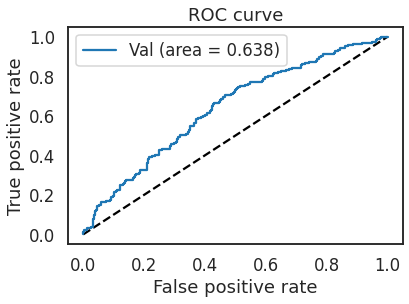

<Figure size 432x288 with 0 Axes>

In [66]:
df = pd.DataFrame({'logits':logits_history, 'pred_label': pred_labels, 'label':true_labels})
fpr, tpr, df_out, roc_auc = vote_score(df_test, logits_history, output_path)

Recall at Precision of 80 is {} 0.024390243902439025


0.024390243902439025

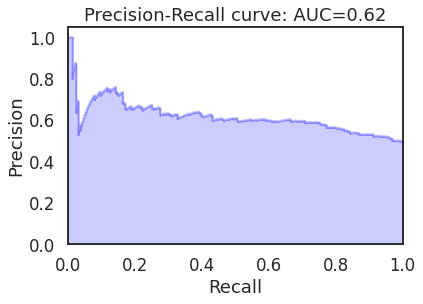

In [67]:
vote_pr_curve(df_test, logits_history, output_path)

In [68]:
df_test['pred_score'] = logits_history
df_sort = df_test.sort_values(by=['ID'])
temp = (df_sort.groupby(['ID'])['pred_score'].agg(max)+df_sort.groupby(['ID'])['pred_score'].agg(sum)/2)/(1+df_sort.groupby(['ID'])['pred_score'].agg(len)/2)

In [69]:
temp.values.max()

0.7624801993370056

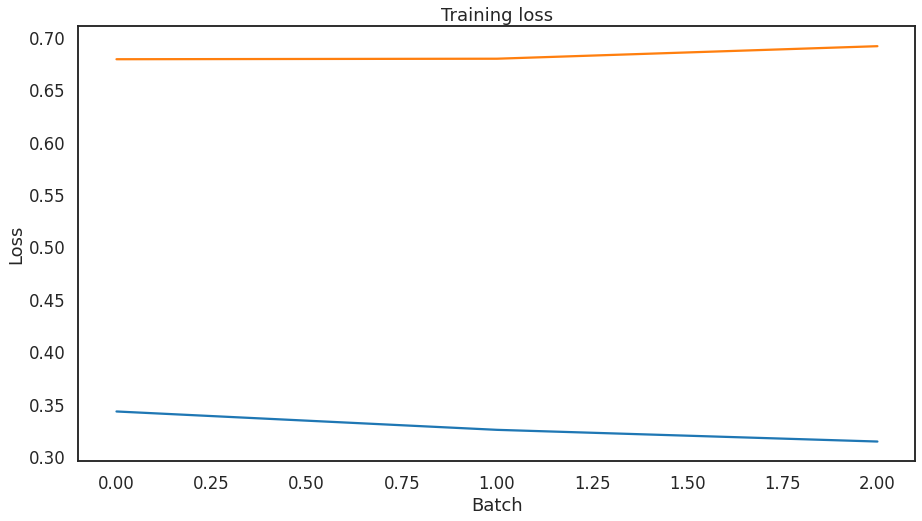

In [70]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_history)
plt.plot(loss_history)
plt.show()

In [74]:
pwd

'/home/x1112373/clinicalBERT/CS598-project/modeling'

In [75]:
from attention_viz import *

In [76]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set_style('white')
sns.set_context('talk', font_scale = 1)
import os
bert_config = BertConfig.from_json_file('/home/x1112373/clinicalBERT/CS598-project/pretraining/config.json')

In [77]:
def transpose_for_scores(config, x):
    new_x_shape = x.size()[:-1] + (config.num_attention_heads, int(config.hidden_size / config.num_attention_heads))
    x = x.view(*new_x_shape)
    return x.permute(0, 2, 1, 3)

In [78]:
def get_attention_scores(model,i,text):
    tokenized=tokenizer.tokenize(text)

    indexed_tokens=tokenizer.convert_tokens_to_ids(tokenized)

    segment_ids=[0]*len(indexed_tokens)
    t_tensor=torch.tensor([indexed_tokens])
    s_ids=torch.tensor([segment_ids])

    outputs_query= []
    outputs_key= []

    def hook_query(module, input, output):
        #print ('in query')
        outputs_query.append(output)

    def hook_key(module, input, output):
        #print ('in key')
        outputs_key.append(output)

    model.bert.encoder.layer[i].attention.self.query.register_forward_hook(hook_query)
    model.bert.encoder.layer[i].attention.self.key.register_forward_hook(hook_key)
    l=model(t_tensor,s_ids)
    
    query_layer = transpose_for_scores(bert_config,outputs_query[0])
    key_layer = transpose_for_scores(bert_config,outputs_key[0])
    
    attention_scores = torch.matmul(query_layer, key_layer.transpose(-1, -2))
    attention_scores = attention_scores / math.sqrt(int(bert_config.hidden_size / bert_config.num_attention_heads))
    attention_probs = nn.Softmax(dim=-1)(attention_scores)
    
    return attention_probs,tokenized

In [79]:
model.to('cpu')

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [80]:
text=' he has experienced acute on chronic diastolic heart failure in the setting of volume overload due to his sepsis.'
x,tokens=get_attention_scores(model,0,text)

In [81]:
map1=np.asarray(x[0][1].detach().numpy())
len(tokens)

24

In [82]:
%matplotlib inline

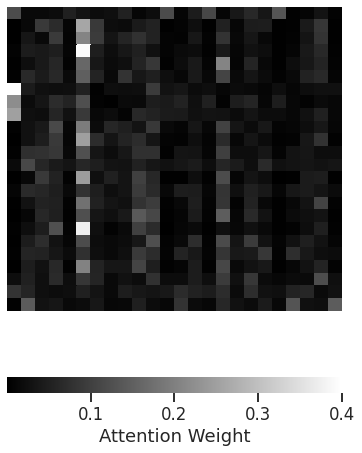

In [83]:
f, ax = plt.subplots(figsize=(6,8))
sns.heatmap(map1, annot=False, fmt="f", ax=ax, xticklabels = False, yticklabels = False, vmax=0.4, cmap='gray', cbar_kws={'label':'Attention Weight', 'orientation':'horizontal'}, rasterized = True)


<Figure size 432x288 with 0 Axes>

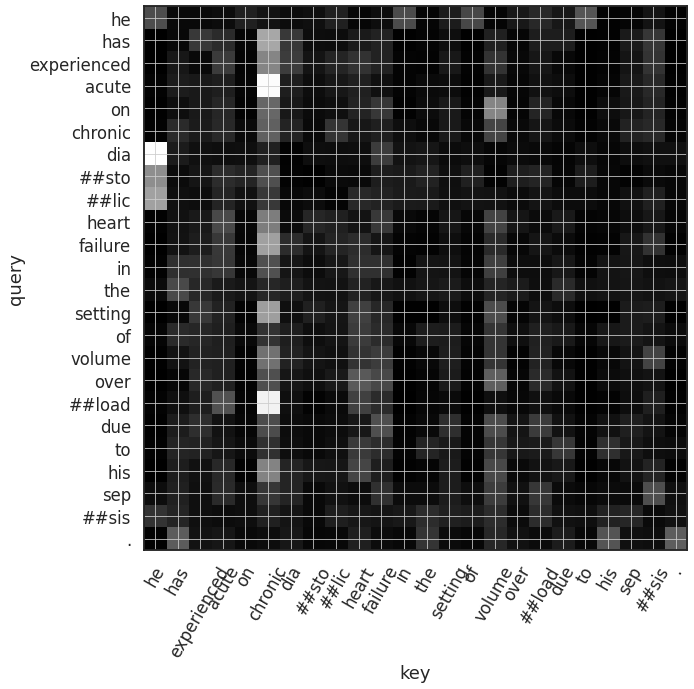

In [84]:
plt.clf()

f=plt.figure(figsize=(10,10))
ax = f.add_subplot(1,1,1)
i=ax.imshow(map1,interpolation='nearest',cmap='gray')

ax.set_yticks(range(len(tokens)))
ax.set_yticklabels(tokens)

ax.set_xticks(range(len(tokens)))
ax.set_xticklabels(tokens,rotation=60)

ax.set_xlabel('key')
ax.set_ylabel('query')

ax.grid(linewidth = 0.8)